In [379]:
import os
import yaml
import glob 
import ephem
import fitsio
import pickle
import desisurvey
import astropy.constants as constants
import astropy.units as units
import numpy as np 
import pylab as pl
import scipy

from desisurvey.utils import get_location, get_date
from astropy.coordinates import Angle
from astropy.time import Time

from scipy.interpolate import interp1d
from speclite import filters
from multiprocessing import Pool
from functools import partial
from desispec.io.fluxcalibration import read_average_flux_calibration

# -- astropy --
import astropy.time
import astropy.coordinates

from astropy.io import fits 
from astropy import units as u
from astropy.table import Table

# -- eso sky --
# from skycalc_cli import skycalc 

# -- feasibgs -- 
from feasibgs import util as UT
from feasibgs import skymodel as Sky
from feasibgs.skymodel import Isky_newKS_twi, _specsim_initialize

# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt

In [395]:
specsim_sky     = _specsim_initialize('desi', model='regression')

In [396]:
def sky_KS(airmass, moonill, moonalt, moonsep):
    ''' calculate original KS sky model 
    '''
    
    specsim_wave = specsim_sky._wavelength # Ang
    specsim_sky.airmass = airmass
    specsim_sky.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    specsim_sky.moon.moon_zenith = (90. - moonalt) * u.deg
    specsim_sky.moon.separation_angle = moonsep * u.deg
    # original KS coefficient 
    specsim_sky.moon.KS_CR = 10**5.36 
    specsim_sky.moon.KS_CM0 = 6.15 
    specsim_sky.moon.KS_CM1 = 40.
    
    return specsim_wave.value, specsim_sky.surface_brightness.value

In [8]:
!pip install git+https://github.com/desi-bgs/feasiBGS.git --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/desi-bgs/feasiBGS.git to /tmp/pip-req-build-u71z65ae
  Running command git clone -q https://github.com/desi-bgs/feasiBGS.git /tmp/pip-req-build-u71z65ae
  Created wheel for feasibgs: filename=feasibgs-0.1-py3-none-any.whl size=47422 sha256=780a727dc8894f80081bc1e59c97a12e2d41d44987cc1650257a7160113369c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-dsaignfi/wheels/f7/d7/9d/824c3b88b5bd8c28b8c576f20984e3cf31a80def7e3deae10a
Successfully built feasibgs


In [145]:
mayall = get_location()

In [148]:
emayall           = ephem.Observer()
emayall.lon       = ephem.degrees(mayall.lon.value * np.pi / 180.)
emayall.lat       = ephem.degrees(mayall.lat.value * np.pi / 180.)
emayall.elevation = mayall.height.value

In [149]:
moon = ephem.Moon()

In [56]:
def flux_to_mag(flux):
    return 22.5 - 2.5*np.log10(flux*10**9)

def get_mag(wsky, Isky, band): 
    ''' 
    get magnitude of sky surface brightness
    '''
    Isky *= 1e-17 # erg/s/cm^2/A/sq. arcsec.

    filter_response = filters.load_filter('decam2014-{}'.format(band))
    moon_flux, sky_wlen = filter_response.pad_spectrum(Isky, wsky)
    sky_brightness = filter_response.get_ab_maggies(moon_flux, sky_wlen)
    return flux_to_mag(sky_brightness)

In [23]:
conditions = Table.read('sv1-exposures.fits')

In [24]:
conditions

<Table length=407>
 NIGHT   EXPID TILEID ... GFA_TRANSPFRAC_MED GFA_TRANSPFRAC_MAX
 int64   int64 int64  ...      float32            float32      
-------- ----- ------ ... ------------------ ------------------
20201214 67710  80605 ...         0.08944121         0.13066149
20201214 67711  80605 ...         0.07898156         0.13812387
20201214 67712  80605 ...         0.11708183         0.18699387
20201214 67713  80605 ...         0.12895063         0.19069208
20201214 67733  80606 ...         0.20650734         0.28864324
20201214 67744  80607 ...         0.30781493          0.4365464
20201214 67765  80607 ...         0.34763667         0.49000615
20201214 67766  80607 ...         0.34158522         0.46501502
20201214 67767  80607 ...         0.33658576         0.48688516
20201214 67768  80607 ...         0.43163538           0.500158
     ...   ...    ... ...                ...                ...
20210103 70754  80654 ...          0.6999301          0.7666418
20210103 70755  80655 ...         0.65009916          0.6874281
20210103 70756  80655 ...          0.7043578         0.73408395
20210103 70757  80655 ...         0.71180046          0.7379902
20210103 70758  80656 ...          0.5840259           0.655087
20210103 70759  80656 ...         0.64366066          0.7118279
20210103 70760  80656 ...         0.67078155          0.7092249
20210103 70762  80660 ...          0.7012791         0.73739713
20210103 70763  80660 ...          0.7169724         0.75333726
20210103 70764  80660 ...          0.5981858          0.7339741

In [138]:
np.unique(conditions['NIGHT'])

<Column name='NIGHT' dtype='int64' length=13>
20201214
20201215
20201216
20201217
20201218
20201219
20201220
20201221
20201222
20201223
20210101
20210102
20210103

In [25]:
nominal_dark = 21.07

In [26]:
dmab = -2.5 * np.log10(2.5)

In [27]:
bright_lim = nominal_dark + dmab

In [29]:
bright_lim

20.075149978319907

In [31]:
bright_conditions = conditions[conditions['GFA_SKY_MAG_AB_MED'] <= bright_lim]

In [32]:
bright_conditions

<Table length=160>
 NIGHT   EXPID TILEID ... GFA_TRANSPFRAC_MED GFA_TRANSPFRAC_MAX
 int64   int64 int64  ...      float32            float32      
-------- ----- ------ ... ------------------ ------------------
20201214 67733  80606 ...         0.20650734         0.28864324
20201215 67987  80605 ...         0.26147586          0.4075628
20201215 68042  80610 ...         0.40866235         0.45239756
20201220 69033  80611 ...         0.46880674          0.5453652
20201220 69035  80611 ...         0.46427566         0.51578575
20201222 69398  80616 ...         0.35317096          0.5147497
20201222 69400  80617 ...         0.40833426         0.51034033
20201222 69401  80617 ...         0.11700623         0.32593408
20201222 69402  80617 ...         0.18250303         0.25139597
20201222 69403  80617 ...         0.27814493         0.41357338
     ...   ...    ... ...                ...                ...
20210103 70754  80654 ...          0.6999301          0.7666418
20210103 70755  80655 ...         0.65009916          0.6874281
20210103 70756  80655 ...          0.7043578         0.73408395
20210103 70757  80655 ...         0.71180046          0.7379902
20210103 70758  80656 ...          0.5840259           0.655087
20210103 70759  80656 ...         0.64366066          0.7118279
20210103 70760  80656 ...         0.67078155          0.7092249
20210103 70762  80660 ...          0.7012791         0.73739713
20210103 70763  80660 ...          0.7169724         0.75333726
20210103 70764  80660 ...          0.5981858          0.7339741

In [33]:
Isky_newKS_twi?

Signature: Isky_newKS_twi(airmass, moonill, moonalt, moonsep, sunalt, sunsep)
Docstring:
Sky surface brightness as a function of airmass, moon parameters, and sun parameters.
The sky surface brightness uses the KS model scaling with coefficients re-fit to match
BOSS sky data and includes a twilight contribution from Parker's thesis. 

:param airmass: 
    airmass 

:param moonill:  
    moon illumination fraction: 0 - 1 

:param moonalt:  
    moon altitude: 0 - 90 deg 

:param moonsep:  
    moon separation angle: 0 - 180 deg 

:param sunalt:
    sun altitude: 0 - 90 deg 

:param sunsep: 
    sun separation: 0 - 90 deg 

:return specsim_wave, Isky: 
    returns wavelength [Angstrom] and sky surface brightness [$10^{-17} erg/cm^{2}/s/\AA/arcsec^2$]
File:      ~/.local/lib/python3.8/site-packages/feasibgs/skymodel.py
Type:      function


In [133]:
sv0_conditions = Table.read('desi_sv0_exposures_gfa.fits')

<Table length=41>
expid  night   tileid exptime ... fiber_fracflux_max  ngfa     ebv    
int64  int64   int64  float32 ...      float32       int64   float32  
----- -------- ------ ------- ... ------------------ ----- -----------
55380 20200314  67230   900.0 ...           0.441228   534 0.029372929
55381 20200314  67230   900.0 ...          0.4796432   534 0.029372929
55382 20200314  67230   900.0 ...         0.64808327   534 0.029372929
55395 20200314  68000   900.0 ...                nan   534 0.011782864
55396 20200314  68000   900.0 ...          0.5421777   534 0.011782864
55432 20200314  66014   450.0 ...          0.6150159   264 0.018267725
55433 20200314  66014   450.0 ...         0.65173006   264 0.018267725
55434 20200314  66014   450.0 ...                nan   264 0.018267725
55435 20200314  66014   450.0 ...                nan   264 0.018267725
55442 20200314  66000   450.0 ...          0.6880951   264 0.011238488
  ...      ...    ...     ... ...                ...   ...         ...
55627 20200315  68002   900.0 ...           0.689292   534  0.02130655
55628 20200315  68002   900.0 ...          0.6677147   534  0.02130655
55639 20200315  67142   900.0 ...         0.63875407   534 0.030442514
55640 20200315  67142   900.0 ...          0.6650276   534 0.030442514
55641 20200315  67142   900.0 ...         0.66349757   534 0.030442514
55642 20200315  67142   900.0 ...         0.71743834   534 0.030442514
55643 20200315  67142   900.0 ...          0.7168714   534 0.030442514
55654 20200315  66003   450.0 ...          0.6909119   264 0.018030789
55655 20200315  66003   450.0 ...         0.68425214   264 0.018030789
55656 20200315  66003   450.0 ...          0.7398737   264 0.018030789

In [137]:
bright_sv0_conditions = sv0_conditions[sv0_conditions['sky_mag_ab_med'] <= bright_lim]
bright_sv0_conditions

<Table length=15>
expid  night   tileid exptime ... fiber_fracflux_max  ngfa     ebv    
int64  int64   int64  float32 ...      float32       int64   float32  
----- -------- ------ ------- ... ------------------ ----- -----------
55432 20200314  66014   450.0 ...          0.6150159   264 0.018267725
55433 20200314  66014   450.0 ...         0.65173006   264 0.018267725
55434 20200314  66014   450.0 ...                nan   264 0.018267725
55435 20200314  66014   450.0 ...                nan   264 0.018267725
55443 20200314  66000   450.0 ...         0.69482756   264 0.011238488
55444 20200314  66000   450.0 ...          0.7542814   264 0.011238488
55445 20200314  66000   450.0 ...         0.72885567   264 0.011238488
55456 20200314  65008   450.0 ...         0.75293434   264         0.0
55457 20200314  65008   450.0 ...                nan   264         0.0
55458 20200314  65008   450.0 ...                nan   264         0.0
55459 20200314  65008   450.0 ...                nan   264         0.0
55475 20200314  66019   450.0 ...         0.70110846   264 0.017385393
55476 20200314  66019   450.0 ...                nan   264 0.017385393
55477 20200314  66019   450.0 ...           0.673462   264 0.017385393
55478 20200314  66019   450.0 ...          0.7059117   264 0.017385393

In [195]:
# AR DESI telescope geometric area (cm2) and fiber area (arcsec2)
# AR for computing SKY_RMAG_AB
fn = os.path.join(os.getenv("DESIMODEL"), "data", "desi.yaml")
f = open(fn, "r")
desi = yaml.safe_load(f)
f.close()
telap_cm2 = desi["area"]["geometric_area"] * 1e4  # AR telescope geometric area in cm2
fiber_area_arcsec2 = (
    np.pi * (desi["fibers"]["diameter_arcsec"] / 2.0) ** 2
)  # fiber area in arcsec2

In [204]:
# AR/DK exposure depths utilities
def load_spec_thru(path=os.getenv("DESIMODEL") + "/data/throughput/"):
    thru = {}
    for camera in ["b", "r", "z"]:
        data = fitsio.read(f"{path}/thru-{camera}.fits", "THROUGHPUT")
        thru[camera] = np.interp(
            fullwave[cslice[camera]], data["wavelength"], data["throughput"]
        )
    return thru

In [197]:
# AR folders / files
sv1dir = "/global/cfs/cdirs/desi/users/raichoor/fiberassign-sv1/"
dailydir = "/global/cfs/cdirs/desi/spectro/redux/daily/"
pixwfn = "/global/cfs/cdirs/desi/target/catalogs/dr9/0.47.0/pixweight/sv1/resolve/dark/sv1pixweight-dark.fits"
desfn = os.path.join(sv1dir, "misc", "des_footprint.txt")
gfafn = np.sort(
    glob.glob(
        "/global/cfs/cdirs/desi/users/ameisner/GFA/conditions/offline_all_guide_ccds_SV1-thru_20??????.fits"
    )
)[-1]

In [198]:
# AR/DK DESI spectra wavelengths
wmin, wmax, wdelta = 3600, 9824, 0.8
fullwave = np.round(np.arange(wmin, wmax + wdelta, wdelta), 1)
cslice = {"b": slice(0, 2751), "r": slice(2700, 5026), "z": slice(4900, 7781)}

In [205]:
spec_thru = load_spec_thru()

In [240]:
read_average_flux_calibration?

Signature: read_average_flux_calibration(filename)
Docstring:
Read average flux calibration file; returns an AverageFluxCalib object
    
File:      ~/repos/desispec/py/desispec/io/fluxcalibration.py
Type:      function


In [220]:
bcal=read_average_flux_calibration("/global/cfs/cdirs/desi/spectro/desi_spectro_calib/trunk/spec/fluxcalib/fluxcalibnight-b-20201216.fits")
rcal=read_average_flux_calibration("/global/cfs/cdirs/desi/spectro/desi_spectro_calib/trunk/spec/fluxcalib/fluxcalibnight-r-20201216.fits")
zcal=read_average_flux_calibration("/global/cfs/cdirs/desi/spectro/desi_spectro_calib/trunk/spec/fluxcalib/fluxcalibnight-z-20201216.fits")

In [241]:
bcal?

Type:           AverageFluxCalib
String form:    <desispec.averagefluxcalibration.AverageFluxCalib object at 0x2aaae86f74c0>
File:           ~/repos/desispec/py/desispec/averagefluxcalibration.py
Docstring:      <no docstring>
Init docstring:
Lightweight wrapper object for average flux calibration data

Args:
    wave : 1D[nwave] input wavelength (Angstroms)
    average_calib: 1D[nwave] average calibration vector at pivot airmass and seeing
    atmospheric_extinction : 1D[nwave] extinction term, magnitude
    seeing_term : 1D[nwave], magnitude
    pivot_airmass : float, airmass value for average_calib
    pivot_seeing : float, seeing value for average_calib (same definition and unit as SEEING keyword in images)
    atmospheric_extinction_uncertainty : 1D[nwave] uncertainty on extinction term, magnitude
    seeing_term_uncertainty : 1D[nwave], uncertainty on seeing term magnitude

All arguments become attributes,

The calib vector should be such that

    [1e-17 erg/s/cm^2/A] = [photons

In [245]:
bcal.value?

Signature: bcal.value(airmass, seeing)
Docstring:
Returns calibration vector for this airmass and seeing

Args:
   airmass : float, airmass, as defined in image headers
   seeing ; float , seeing in arcsec FWHM, as defined in image headers

Returns:
   calibation vector : 1D[nwave] corresponfing to this class wavelength array self.wave, units are [photons/A]/[1e-17 erg/s/cm^2/A]
File:      ~/repos/desispec/py/desispec/averagefluxcalibration.py
Type:      method


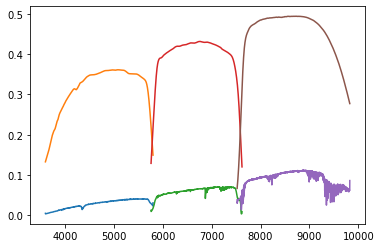

In [248]:
for band, cal in zip(['b', 'r', 'z'], [bcal, rcal, zcal]):
    pl.plot(cal.wave, cal.value(1., 1.))
    pl.plot(cal.wave, spec_thru[band])

In [332]:
# AR r-band sky mag / arcsec2 from sky-....fits files
def get_sky_rmag_ab(night, expid, exptime, ftype="model", redux="daily", smoothing=100.0):
    # AR ftype = "data" or "model"
    # AR redux = "daily" or "blanc"
    # AR if ftype = "data" : read the sky fibers from frame*fits + apply flat-field
    # AR if ftype = "model": read the sky model from sky*.fits for the first fiber of each petal (see DJS email from 29Dec2020)
    # AR those are in electron / angstrom
    # AR to integrate over the decam-r-band, we need cameras b and r
    if ftype not in ["data", "model"]:
        sys.exit("ftype should be 'data' or 'model'")
    sky = np.zeros(len(fullwave))
    reduxdir = dailydir.replace("daily", redux)
    
    # AR see AK email [desi-data 5218]
    if redux == "blanc":
        specs = ["0", "1", "3", "4", "5", "7", "8", "9"]
    else:
        specs = np.arange(10, dtype=int).astype(str)
        
    for camera in ["b", "r", "z"]:
        norm_cam = np.zeros(len(fullwave[cslice[camera]]))
        sky_cam = np.zeros(len(fullwave[cslice[camera]]))
        
        for spec in specs:
            # AR data
            if ftype == "data":
                frfn = os.path.join(
                    reduxdir,
                    "exposures",
                    "{}".format(night),
                    expid,
                    "frame-{}{}-{}.fits".format(camera, spec, expid),
                )
                flfn = os.path.join(
                    reduxdir,
                    "calibnight",
                    "{}".format(night),
                    "fiberflatnight-{}{}-{}.fits".format(camera, spec, night),
                )
                if not os.path.isfile(frfn) or not os.path.isfile(flfn):
                    print("Skipping non-existent {}, {}".format(frfn, flfn))
                else:
                    fr = read_frame(frfn, skip_resolution=True)
                    fl = fiberflat.read_fiberflat(flfn)
                    apply_fiberflat(fr, fl)
                    # AR cutting on sky fibers with at least one valid pixel
                    ii = (fr.fibermap["OBJTYPE"] == "SKY") & (fr.ivar.sum(axis=1) > 0)
                    # AR frame*fits are in e- / angstrom ; adding the N sky fibers
                    # sky_cam += fr.flux[ii, :].sum(axis=0)
                    # nspec += ii.sum()
                    sky_cam += (fr.flux[ii, :] * fr.ivar[ii, :]).sum(axis=0)
                    norm_cam += fr.ivar[ii, :].sum(axis=0)
                    
            # AR model
            if ftype == "model":
                fn = os.path.join(
                    reduxdir,
                    "exposures",
                    "{}".format(night),
                    expid,
                    "sky-{}{}-{}.fits".format(camera, spec, expid),
                )
                if not os.path.isfile(fn):
                    print("Skipping non-existent {}".format(fn))
                    
                else:
                    fd = fitsio.FITS(fn)
                    
                    assert np.allclose(
                        fullwave[cslice[camera]], fd["WAVELENGTH"].read()
                    )
                    
                    fd = fitsio.FITS(fn)

                    with fd as hdus:
                        exptime = hdus[0].read_header()['EXPTIME']
                        
                        flux = hdus['SKY'].read()
                        ivar = hdus['IVAR'].read()
                        mask = hdus['MASK'].read()
                
                        # Verify that we have the expected wavelengths.
                        # assert np.allclose(detected[camera].wave, hdus['WAVELENGTH'].read())
                        # Verify that ivar is purely statistical.
                        # assert np.array_equal(ivar, hdus['STATIVAR'].read())
                        # Verify that the model has no masked pixels.
                        # assert np.all((mask == 0) & (ivar > 0))
                        # Verify that the sky model is constant.
                        # assert np.array_equal(np.max(ivar, axis=0), np.min(ivar, axis=0))
              
                        # assert np.allclose(np.max(flux, axis=0), np.min(flux, axis=0))
                        # There are actually small variations in flux!
                        # TODO: figure out where these variations come from.
                        # For now, take the median over fibers.
                        if fd["IVAR"][0, :][0].max() > 0:
                            sky_cam  += fd["SKY"][0, :][0]  # AR reading the first fiber only
                            norm_cam += np.ones(len(fullwave[cslice[camera]]))
                        
                        # sky_cam  += np.median(flux, axis=0)
                        # norm_cam += np.ones(len(fullwave[cslice[camera]]))
                    
                    fd.close()

        # AR sky model flux in incident photon / angstrom / s
        # if nspec > 0:
        keep = norm_cam > 0
        
        if keep.sum() > 0:
            sky[cslice[camera]][keep] = (
                sky_cam[keep] / norm_cam[keep] / exptime / spec_thru[camera][keep]
            )
        else:
            print("{}-{}-{}: no spectra for {}".format(night, expid, camera, ftype))
            
    # AR sky model flux in erg / angstrom / s (using the photon energy in erg)
    e_phot_erg = (
        constants.h.to(units.erg * units.s)
        * constants.c.to(units.angstrom / units.s)
        / (fullwave * units.angstrom)
    )
    sky *= e_phot_erg.value
    # AR sky model flux in erg / angstrom / s / cm**2 / arcsec**2
    sky /= telap_cm2 * fiber_area_arcsec2
    
    if smoothing > 0.0: 
        sky = scipy.ndimage.gaussian_filter1d(sky, 100.) 
    
    # AR integrate over the DECam r-band
    filts = filters.load_filters("decam2014-r")
    
    # AR zero-padding spectrum so that it covers the DECam r-band range
    sky_pad, fullwave_pad = filts.pad_spectrum(sky, fullwave, method="zero")

    return fullwave, sky, filts.get_ab_magnitudes(
        sky_pad * units.erg / (units.cm ** 2 * units.s * units.angstrom),
        fullwave_pad * units.angstrom,
    ).as_array()[0][0]

(array([3600. , 3600.8, 3601.6, ..., 9822.4, 9823.2, 9824. ]),
 array([2.76253463e-17, 2.76255388e-17, 2.76259230e-17, ...,
        1.48356284e-17, 1.48361992e-17, 1.48364568e-17]),
 20.241133259596737)

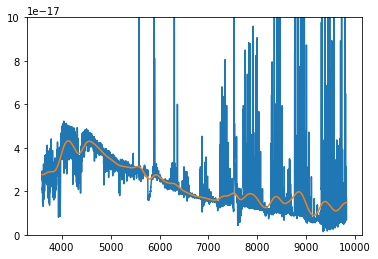

In [359]:
get_sky_rmag_ab('20210103', '00070758', 300.094, 'model', redux="daily")

In [278]:
bright_conditions

<Table length=160>
 NIGHT   EXPID TILEID ... GFA_TRANSPFRAC_MED GFA_TRANSPFRAC_MAX
 int64   int64 int64  ...      float32            float32      
-------- ----- ------ ... ------------------ ------------------
20201214 67733  80606 ...         0.20650734         0.28864324
20201215 67987  80605 ...         0.26147586          0.4075628
20201215 68042  80610 ...         0.40866235         0.45239756
20201220 69033  80611 ...         0.46880674          0.5453652
20201220 69035  80611 ...         0.46427566         0.51578575
20201222 69398  80616 ...         0.35317096          0.5147497
20201222 69400  80617 ...         0.40833426         0.51034033
20201222 69401  80617 ...         0.11700623         0.32593408
20201222 69402  80617 ...         0.18250303         0.25139597
20201222 69403  80617 ...         0.27814493         0.41357338
     ...   ...    ... ...                ...                ...
20210103 70754  80654 ...          0.6999301          0.7666418
20210103 70755  80655 ...         0.65009916          0.6874281
20210103 70756  80655 ...          0.7043578         0.73408395
20210103 70757  80655 ...         0.71180046          0.7379902
20210103 70758  80656 ...          0.5840259           0.655087
20210103 70759  80656 ...         0.64366066          0.7118279
20210103 70760  80656 ...         0.67078155          0.7092249
20210103 70762  80660 ...          0.7012791         0.73739713
20210103 70763  80660 ...          0.7169724         0.75333726
20210103 70764  80660 ...          0.5981858          0.7339741

In [397]:
def process_one(condition, campaign='SV1'):
    if campaign == 'SV0':
        airmass    = condition['airmass_med']
        mjdobs     = condition['mjdobs']
        
        t = Time(mjdobs, format='mjd', scale='utc')
        emayall.date = t.iso

        moon.compute(emayall)
    
        moon_alt   = moon.alt * (180. / np.pi)
        moon_frac  = moon.moon_phase
        moon_sep   = condition['moon_sep_deg_med']
        
        obs_rsky   = None
    
    elif campaign == 'SV1':
        airmass    = condition['GFA_AIRMASS_MED']
        moon_frac  = condition['GFA_MOON_ILLUMINATION_MED']
        moon_alt   = 90. - condition['GFA_MOON_ZD_DEG_MED']
        moon_sep   = condition['GFA_MOON_SEP_DEG_MED']

        night      = str(condition['NIGHT'])
        expid      = '{:08d}'.format(condition['EXPID'])
        exptime    = condition['EXPTIME']
        
        # decam2014-r-band sky brightness in AB mag / arcsec2
        obs_rsky   = condition['SPECMODEL_SKY_RMAG_AB']	
        
    else:
        raise ValueError('Unavailable campaign ({})'.format(campaign))
        
    sun_alt    = -90.
    sun_sep    =  90.
    
    ow_ks, oks_i = sky_KS(airmass, moon_frac, moon_alt, moon_sep)

    sample     = (ow_ks >= 3600.) & (ow_ks <= 9824.)

    oks_i      = oks_i[sample][::8]
    ow_ks      = ow_ks[sample][::8]
    
    oks_i      = scipy.ndimage.gaussian_filter1d(oks_i, 100.) 
    
    # wavelength [Angstrom] and Sky Surface Brightness [$10^{-17} erg/cm^{2}/s/\AA/arcsec^2$]
    w_ks, ks_i = Isky_newKS_twi(airmass, moon_frac, moon_alt, moon_sep, sun_alt, sun_sep)
    
    sample     = (w_ks.value >= 3600.) & (w_ks.value <= 9824.)

    ks_i       = ks_i[sample][::8]
    w_ks       = w_ks[sample][::8]
    
    ks_i       = scipy.ndimage.gaussian_filter1d(ks_i, 100.) 

    assert np.all(ow_ks == w_ks.value)
    
    # decam2014-r-band sky brightness in AB mag / arcsec2
    model_rsky = get_mag(w_ks, ks_i, 'r')
    
    new_rsky   = get_sky_rmag_ab(night, expid, exptime, 'model', redux="daily")
    
    return  airmass, moon_frac, moon_alt, moon_sep, model_rsky, obs_rsky, (w_ks, ks_i), new_rsky, (ow_ks, oks_i)

In [398]:
with Pool(12) as p:
    # ordered (on receipt, not production).
    results = p.map(process_one, bright_conditions)

AIRMASS 	 MOONFRAC 	 MOONALT 	 MOONSEP 	 SPEC_RSKY 	 GFA_RSKY 	MODEL_RSKY
1.40 		 0.00 		 -64.37 	  118.25 	 21.36 		 19.60 		20.84
1.37 		 0.03 		 -48.91 	  104.56 	 21.48 		 19.77 		20.83
1.17 		 0.04 		 -62.12 	  135.09 	 21.28 		 20.06 		20.81
1.00 		 0.42 		 +28.80 	  54.83 	 21.15 		 19.95 		20.10
1.01 		 0.42 		 +25.34 	  54.67 	 21.20 		 20.01 		20.11
1.06 		 0.61 		 +58.83 	  32.14 	 19.77 		 19.39 		19.37
1.03 		 0.61 		 +58.49 	  27.25 	 19.30 		 19.27 		19.35
1.04 		 0.61 		 +57.90 	  27.24 	 17.94 		 17.59 		19.34
1.06 		 0.61 		 +56.98 	  27.23 	 18.48 		 18.28 		19.33
1.08 		 0.61 		 +55.85 	  27.22 	 18.32 		 18.17 		19.31
1.10 		 0.61 		 +54.48 	  27.22 	 18.79 		 18.56 		19.30
1.00 		 0.61 		 +53.23 	  33.41 	 19.47 		 18.60 		19.41
1.00 		 0.61 		 +52.09 	  33.35 	 19.28 		 18.49 		19.41
1.00 		 0.61 		 +50.87 	  33.29 	 19.33 		 18.50 		19.41
1.01 		 0.61 		 +49.58 	  33.23 	 19.49 		 19.06 		19.41
1.01 		 0.61 		 +48.23 	  33.17 	 19.44 		 19.03 		19.40
1.02 		 0.6

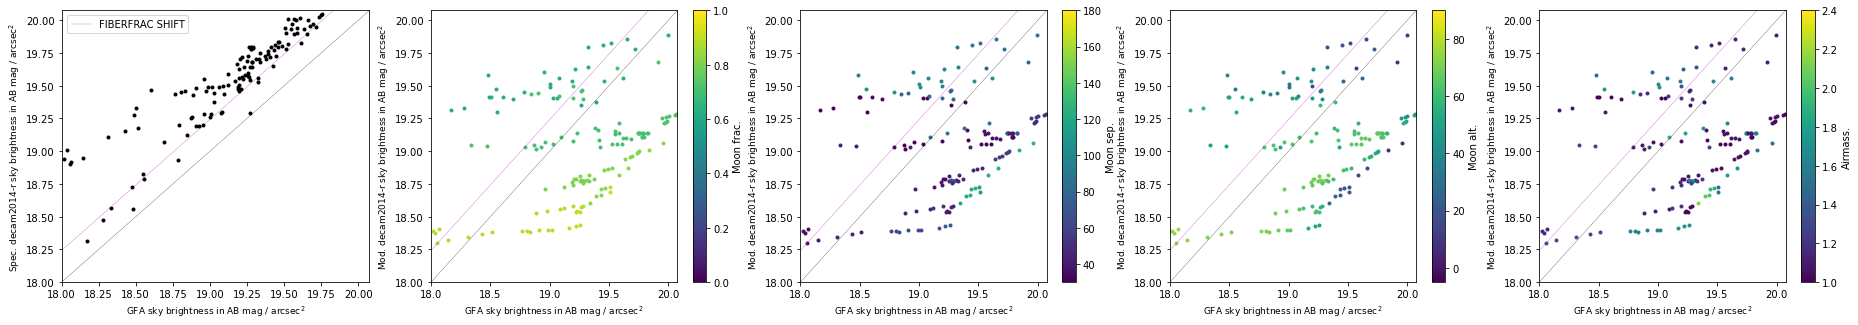

In [404]:
fig, axes = plt.subplots(1, 5, figsize=(32,5))

xs = np.arange(18., 21., 0.1)

for ax in axes:
    ax.plot(xs, xs, c='k', lw=0.25)
    ax.plot(xs, xs + 0.242, c='m', lw=0.25, label='FIBERFRAC SHIFT')

axes[0].legend()
    
print('AIRMASS \t MOONFRAC \t MOONALT \t MOONSEP \t SPEC_RSKY \t GFA_RSKY \tMODEL_RSKY')

for i, (condition, result) in enumerate(zip(bright_conditions, results)):
    airmass, moon_frac, moon_alt, moon_sep, model_rsky, spec_rsky, (w_ks, ks_i), new_rsky, (ow_ks, oks_i) = result
    
    gfa_rsky = condition['GFA_SKY_MAG_AB_MED']
    
    print('{:.2f} \t\t {:.2f} \t\t {:+02.2f} \t {: 3.2f} \t {:.2f} \t\t {:.2f} \t\t{:.2f}'.format(airmass, moon_frac, moon_alt, moon_sep, spec_rsky, gfa_rsky, model_rsky))
    
    axes[0].plot(gfa_rsky, spec_rsky, '.', c='k')
    
    sc1 = axes[1].scatter(gfa_rsky, model_rsky, c=moon_frac, marker='.', vmin=0.,  vmax=1.)
    sc2 = axes[2].scatter(gfa_rsky, model_rsky, c=moon_sep,  marker='.', vmin=30., vmax=180.)
    sc3 = axes[3].scatter(gfa_rsky, model_rsky, c=moon_alt,  marker='.', vmin=-5., vmax=90.)
    sc4 = axes[4].scatter(gfa_rsky, model_rsky, c=airmass,   marker='.', vmin=1.,  vmax=2.4)
    
print('\n\n')
    
fig.colorbar(sc1, ax=axes[1], label='Moon frac.')
fig.colorbar(sc2, ax=axes[2], label='Moon sep.')
fig.colorbar(sc3, ax=axes[3], label='Moon alt.')
fig.colorbar(sc4, ax=axes[4], label='Airmass.')

for ax in axes:
    ax.set_xlim(18.0, bright_lim)
    ax.set_ylim(18.0, bright_lim)
    
axes[0].set_xlabel('GFA sky brightness in AB mag / arcsec$^2$', fontsize=9.)
axes[0].set_ylabel('Spec. decam2014-r sky brightness in AB mag / arcsec$^2$', fontsize=9.)

for i in np.arange(1, 5, 1):
    axes[i].set_xlabel('GFA sky brightness in AB mag / arcsec$^2$', fontsize=9.)
    axes[i].set_ylabel('Mod. decam2014-r sky brightness in AB mag / arcsec$^2$', fontsize=9.)

pl.savefig('model_skycomp.pdf')

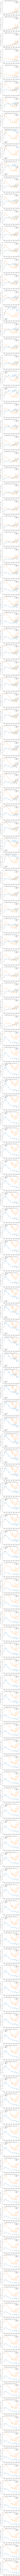

In [403]:
fig, axes = plt.subplots(len(results), 1, figsize=(5, 5 * len(results)))

for i, (result, ax) in enumerate(zip(results, axes)):
    airmass, moon_frac, moon_alt, moon_sep, model_rsky, obs_rsky, (w_ks, ks_i), new_rsky, (ow_ks, oks_i) = result

    expid = '{:08d}'.format(bright_conditions['EXPID'][i])
    night = str(bright_conditions['NIGHT'][i])
    
    ax.plot(w_ks, new_rsky[1] / 1.e-17, label='Observed')
    ax.plot(w_ks,        ks_i / 1.e-17, label='Model')
    # ax.plot(ow_ks,       oks_i, label='KS')
    
    ax.set_title('{} on {} ({:.1f}, {:.1f}, {:.1f}, {:.1f})'.format(expid, night, airmass, moon_frac, moon_alt, moon_sep), fontsize=9.)
    ax.set_ylim(0., 10.)
    
    ax.set_ylabel('$10^{-17}$ ergs / angstrom / $s$ / cm$^2$ / arcsec$^2$')
    
    ax.legend(frameon=False)

## Done.